# Trading Interview Game

Now we have introduced CFR and understand the basics, lets try apply it to a problem inspired by a real interview question from a top quantitative trading firm.

## The Game - Part 1

The game starts with two players, both have to submit a number between 0 and 100 on a piece of paper. After the numbers are submitted, the papers are checked and whoever submitted the larger number must pay the other player their number. 

A few examples:
* Player A submits 90, Player B submits 10. Player B wins so receives \$10.
* Player A submits 15, Player B submits 20. Player A wins so receives \$15.
* Player A submits 1, Player B submits 99. Player A wins so receives \$1.

Imagine you are playing this game and versing an opponent who submits a random number between 1 and 100.
The warm-up question, which can be solved with just paper and pen, is to calculate the optimal number for you to submit, such that you maximise you expected value in this game. 




## Part 1 - Solution

Let $X$ be the number we submit. We can write the probability we win as 
$$
P(X) = 1 - \frac{X}{100}
$$
The payout when we win is simply $X$. The payout when we lose is the other players number. As this will be distributed uniformly between 0 and $X$, the loss will be on average, $X/2$. Therefore we write the expected value as
$$
\mathbb{E}(X) = X P(X) - \frac{X}{2} (1 - P(X)) = X - \frac{3 X^2}{200}
$$

Now we just solve for the maximum of this function (take derivative and set to zero) to get $X_0 = 33$.




## The Game - Part 2

Now we introduce a third player to the game who is perfectly rational, as are you, and there is still a player who submits a random bid. The penalty for losing a game is now greater, as the person who submits the highest number must now pay all the other players their number. If there is a tie for highest bid, they each pay half of the third players number.

For example:
* Player A submits 50, Player B submits 40, Player C submits 30. A loses so pays B \\$40 and pays C \\$30.
* Player A submits 20, Player B submits 50, Player C submits 50. B and C tie to lose, so both pay A \\$10 each.


Our previous strategy of picking a single number is no longer profitable as we will get exploited by the new player. It is likely we will now need to play a mixed strategy. Let's try solve this problem using CFR where we will find the nash equilibrium between player A and player B, and play this strategy to maximise our expected value. 


In [41]:
import numpy as np
import matplotlib.pyplot as plt
N = 101
actions = np.arange(1, N)

In [50]:
'''
Tip: to speedup the computation, we can incorporate the randomness 
of player C's bid into our payoff function by taking an average over 
all 100 possible choices, instead of actually choosing a random number for player C.
'''

# hero number is first
def game_outcome(numbers: list[int]) -> int:
    m = max(numbers)
    max_index = [i for i, j in enumerate(numbers) if j == m]

    outcome = numbers.copy()

    if len(max_index) == 1:
        loss = m - sum(numbers)
        outcome[max_index[0]] = loss

        return outcome[0]

    if len(max_index) == 2:
        loss = m - sum(numbers) / 2
        outcome[max_index[0]] = loss
        outcome[max_index[1]] = loss

        return outcome[0]

    if len(max_index) == 3:
        return 0


In [51]:
'''
Action is the number to submit (100 possible actions)
'''

def payoff(hero_action: int, villain_strategy: np.array(float)) -> float:
    '''
    PAYOFF FUNCTION HERE
    '''
    EV = 0

    for i in range(N):
        for j in range(N):
            nums = [hero_action, i, j]
            EV += game_outcome(nums) * 1/100 * villain_strategy[i]

    return EV

    

In [52]:
'''
Calculate immediate regret for every action
'''
def calculate_immediate_regret(hero_strategy: np.array(float), villain_strategy: np.array(float)) -> np.array(float):
    '''
    IMMEDIATE REGRET 
    '''
    hero_EV = 0
    for a in actions:
        hero_EV += hero_strategy[a] * payoff(a, villain_strategy)

    regrets = np.zeros(N)
    
    for a in actions:
        regrets[a] = payoff(a, villain_strategy) - hero_EV

    return regrets



In [53]:

'''
Calculate new strategy based on accumulated regret for the hero
'''

def calculate_strategy(acc_regrets: np.array(float)) -> np.array(float):
    '''
    CALCULATE NEW STRATEGY
    '''
    positive_regret = np.where(acc_regrets > 0, acc_regrets, 0)

    normalisation = np.sum(positive_regret)

    if normalisation == 0:
        return np.ones(N) / N
        
    return positive_regret / normalisation
        



In [59]:
'''
Run CFR algorithm.
We set initial strategy for player A and B to both pick rock 100% of the time. 
'''

strategyA = np.ones(N) / N
strategyB = np.ones(N) / N

acc_regretsA = np.zeros(N)
acc_regretsB = np.zeros(N)

steps = 500

strat_history = []

for t in range(steps):
    print(t)
    acc_regretsA += calculate_immediate_regret(strategyA, strategyB)
    strategyA = calculate_strategy(acc_regretsA)
    
    acc_regretsB += calculate_immediate_regret(strategyB, strategyA)
    strategyB = calculate_strategy(acc_regretsB)

    strat_history.append(strategyA)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

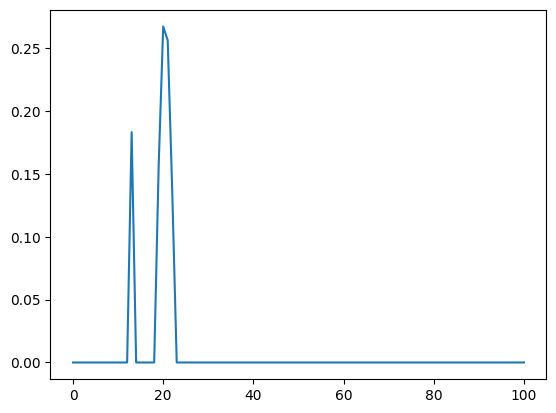

In [62]:
strat_history = np.array(strat_history)

avg_strats = np.cumsum(strat_history, axis=0)
norm = np.sum(avg_strats, axis=1)[:,None]

strats = avg_strats / norm

In [68]:
strats[-1]


array([0.00000000e+00, 1.83945889e-06, 3.42024144e-06, 4.99667649e-06,
       6.56690083e-06, 9.51470655e-06, 1.41972634e-05, 1.88421924e-05,
       2.61295334e-05, 3.55327441e-05, 5.00260572e-05, 7.09618084e-05,
       1.04957414e-04, 2.16083510e-01, 2.38367717e-01, 1.40858410e-01,
       8.48662688e-02, 5.41266117e-02, 3.63297232e-02, 2.93297208e-02,
       3.25093738e-02, 3.70229071e-02, 3.64397565e-02, 2.90237975e-02,
       2.10502059e-02, 1.50695141e-02, 1.00350400e-02, 5.50047761e-03,
       2.26250679e-03, 1.68899448e-03, 1.37182510e-03, 1.12416995e-03,
       9.28085341e-04, 7.71121276e-04, 6.47183962e-04, 5.45659323e-04,
       4.62688458e-04, 3.95172795e-04, 3.39845900e-04, 2.93399448e-04,
       2.52555584e-04, 2.22365236e-04, 1.93373889e-04, 1.71675810e-04,
       1.49315615e-04, 1.34500685e-04, 1.19713709e-04, 1.04553825e-04,
       9.53736946e-05, 8.64816061e-05, 7.73229056e-05, 6.79542497e-05,
       6.13890211e-05, 5.68861401e-05, 5.21977273e-05, 4.73388074e-05,
      

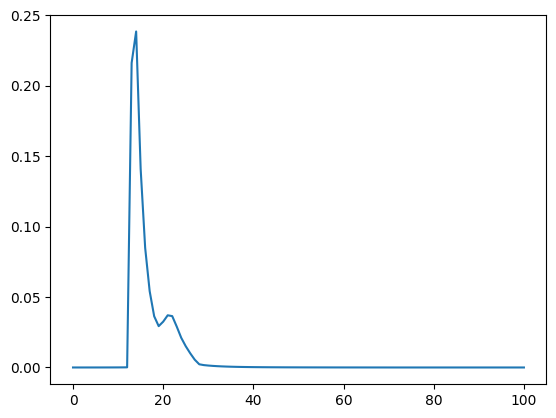

In [69]:
fig, ax = plt.subplots()

ax.plot(strats[-1])
plt.show()